In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [2]:
DATA_DIR = Path().cwd().parent / "data"
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

df = pd.read_json(DATA_DIR / "benchmark_df.json")

df["regret"] = df.apply(lambda x: x["y_true_max"] - np.array(x["y_max_history"]), axis=1)
df = df.drop(columns=["y_true_max", "final_y_max", "y_max_history"]) # cleanup rows
df = df.explode(["regret", "steps"], ignore_index=True) # explode history into seperate rows
df["regret"] = pd.to_numeric(df["regret"], errors="raise")
df

,acq_func,kernel_type,len_scale,n_dim,run_id,steps,regret
0,expected_improvement,se,25,4,0,4,1.053752
1,expected_improvement,se,25,4,0,5,1.053752
2,expected_improvement,se,25,4,0,6,1.053752
3,expected_improvement,se,25,4,0,7,1.053752
4,expected_improvement,se,25,4,0,8,1.053752
...,...,...,...,...,...,...,...
23095,ves_gamma,matern-5/2,25,2,24,21,0.125206
23096,ves_gamma,matern-5/2,25,2,24,22,0.125206
23097,ves_gamma,matern-5/2,25,2,24,23,0.036415
23098,ves_gamma,matern-5/2,25,2,24,24,0.000000


In [3]:
regret_df = df.groupby(['kernel_type', 'n_dim', 'acq_func', 'steps'])
regret_df = regret_df['regret'].agg(['mean', 'std', 'count'])
regret_df # multi-index of key: (kernel_type, n_dim, acq_func, steps)

mean       std  count
kernel_type n_dim acq_func             steps                           
matern-3/2  2     expected_improvement 4      1.120678  0.584719     25
                                       5      0.917334  0.610765     25
                                       6      0.626078  0.523649     25
                                       7      0.527078  0.504962     25
                                       8      0.422529  0.499159     25
...                                                ...       ...    ...
se          4     ves_ramp             21     0.416784  0.451621     25
                                       22     0.395396  0.440585     25
                                       23     0.354939  0.439642     25
                                       24     0.293196  0.368368     25
                                       25     0.293196  0.368368     25

[924 rows x 3 columns]

This gives us a multi-index dataframe with unique keys of `(kernel_type, n_dim, acq_func, steps)` and mean, std, count regret for each row.

To index into a single kernel / dimension, we can use:

In [4]:
regret_df.loc[('matern-3/2', 4)]

mean       std  count
acq_func             steps                           
expected_improvement 4      1.243089  0.638659     25
                     5      1.186119  0.629662     25
                     6      1.133556  0.668060     25
                     7      0.942975  0.686709     25
                     8      0.837741  0.668144     25
...                              ...       ...    ...
ves_ramp             21     0.447282  0.415317     25
                     22     0.439456  0.405527     25
                     23     0.407773  0.407765     25
                     24     0.397844  0.414774     25
                     25     0.359330  0.404704     25

[154 rows x 3 columns]

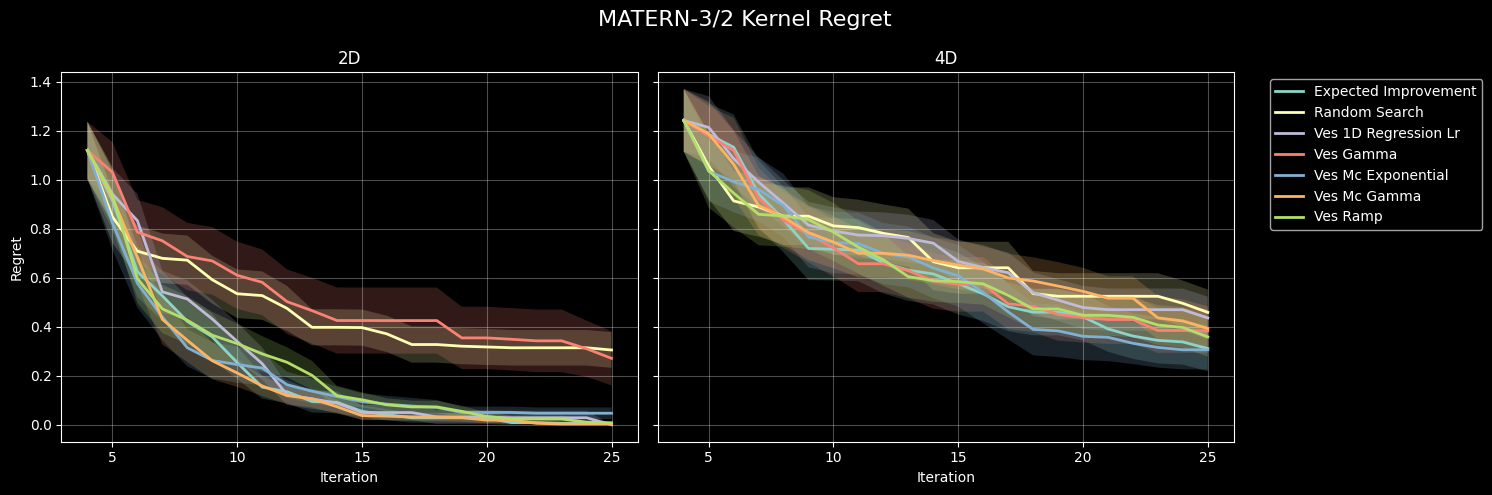

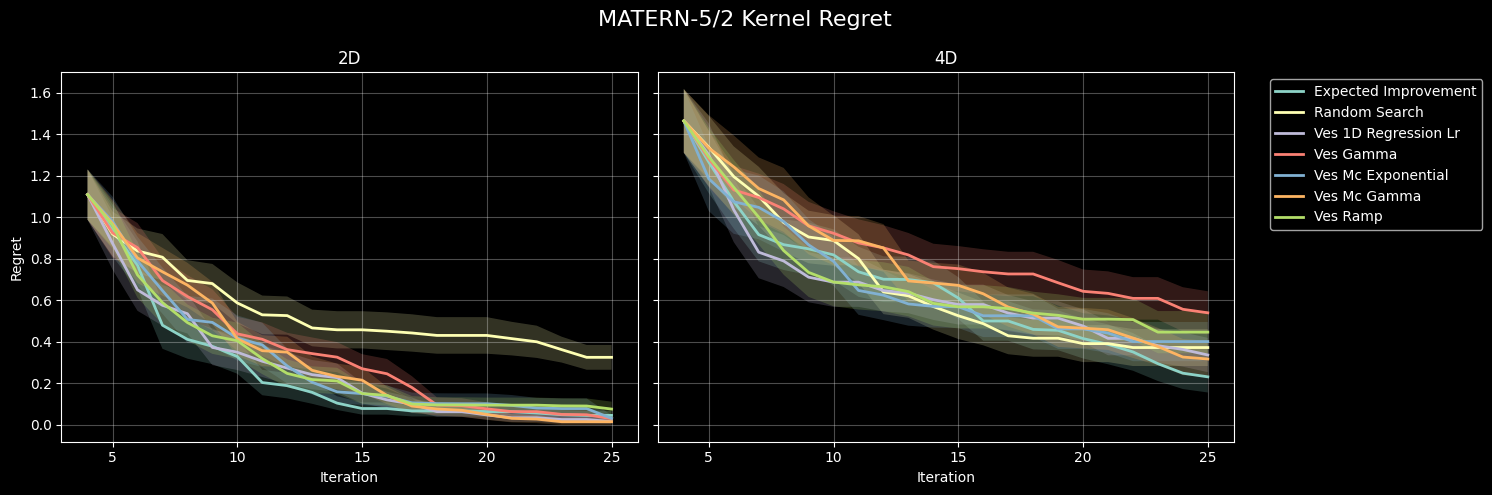

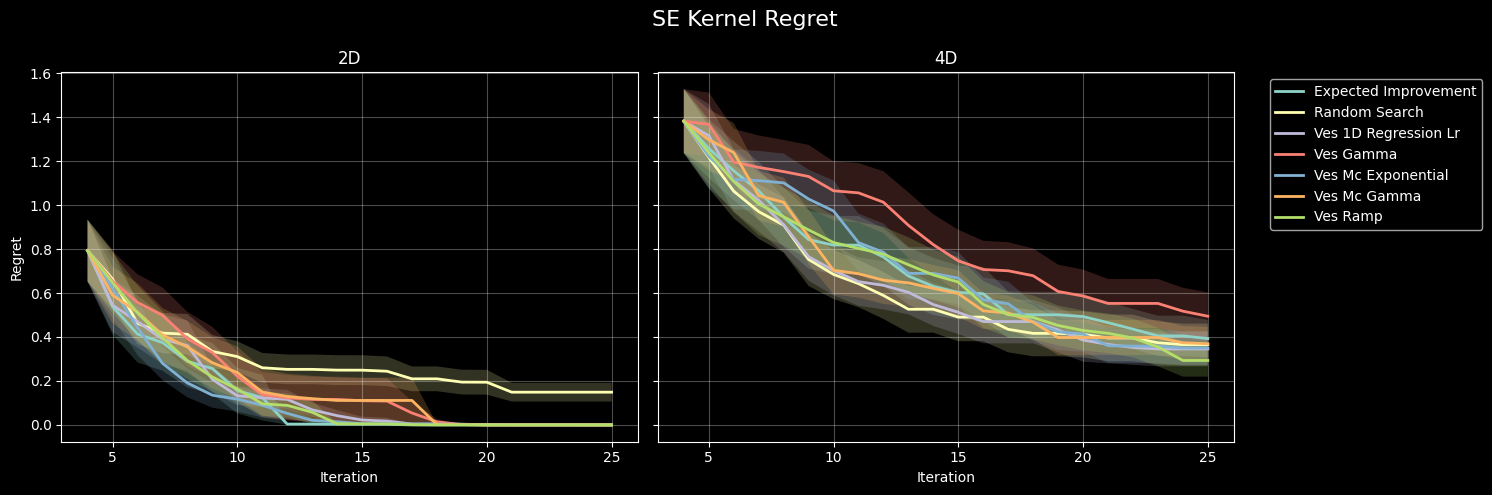

In [5]:
def _plot_single(ax, data, n_dim):
    """Plot regret data for a single dimension on the given axis"""
    for acq_func in data.index.get_level_values('acq_func').unique():
        acq_data = data.loc[acq_func]
        ax.plot(acq_data.index, acq_data['mean'],
                label=acq_func.replace('_', ' ').title(), linewidth=2)

        # Add confidence bands
        standard_error = acq_data['std'] / np.sqrt(acq_data['count'])
        ax.fill_between(acq_data.index,
                        acq_data['mean'] - standard_error,
                        acq_data['mean'] + standard_error,
                        alpha=0.2)

    ax.set_xlabel('Iteration')
    ax.set_title(f'{n_dim}D')
    ax.grid(True, alpha=0.3)

def plot_kernel(kernel_type, kernel_data):
    """Plot regret comparison for a specific kernel type with subplots for each dimension"""
    n_dims = kernel_data.index.get_level_values('n_dim').unique()

    fig, axes = plt.subplots(1, len(n_dims), figsize=(15, 5), sharey=True)
    if len(n_dims) == 1:
        axes = [axes]

    for i, n_dim in enumerate(n_dims):
        data = kernel_data.loc[n_dim]
        _plot_single(axes[i], data, n_dim)

        if i == 0:
            axes[i].set_ylabel('Regret')

    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.suptitle(f'{kernel_type.upper()} Kernel Regret', fontsize=16)
    plt.tight_layout()
    plt.show()

for kernel_type in regret_df.index.get_level_values('kernel_type').unique():
    kernel_data = regret_df.loc[kernel_type]
    plot_kernel(kernel_type, kernel_data)